In [198]:
import numpy as np
from numpy import arange,array,ones,linalg
import math as m
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets
from astropy import utils, io
from astropy.io import fits
from astropy.table import Table, vstack, join

from sklearn.cluster import DBSCAN

from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

%matplotlib inline

#### Define function to plot DBSCAN results

In [185]:
def plot_dbscan(X,db,pltt,data=[]): #pltt=plt if plotting alone

    labels = db.labels_ #list of object's cluster labels; -1 = outlier
    core_samples_mask = np.zeros_like(labels, dtype=bool) #returns array of zeros of length len(labels)
    core_samples_mask[db.core_sample_indices_] = True #if object is core sample,make it "True" instead of "False"
    unique_labels=set(labels) #unique cluster labels

    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # give each cluster a color, black is removed and used for noise.
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.figure(figsize=(10,10))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor=(0,0,0,.5), markersize=6)

        xy = X[class_member_mask & ~core_samples_mask]
        pltt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                  markeredgecolor='k', markersize=6)

    pltt.ticklabel_format(axes='both',useOffset=False)
    
    if pltt==plt:
        pltt.title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
    else: pltt.set_title('%d DBSCAN Clusters,  %d Outliers' % (n_clusters,n_noise))
        

In [227]:
file='/net/dl1/dlusers/katiefasbender/dat_m.fits' 
hdul=fits.open(file)
dat_m=hdul[1].data
Xx=np.column_stack((dat_m['ra'],dat_m['dec']))

## DBSCAN on all measurements, then on outliers

In [228]:
#Compute DBSCAN -----------------------------------------------------------------------------------------
db_1 = DBSCAN(eps=0.000138889, min_samples=2).fit(Xx)
lab = db_1.labels_ #cluster labels

#Get outliers -------------------------------------------------------------------------------------------
outliers=db_1.labels_==-1 #define outliers from DBSCAN labels
X_out=np.column_stack((np.array(dat_m['ra'][outliers]),np.array(dat_m['dec'][outliers]))) #coordinates of DBSCAN outliers

#Compute DBSCAN on outliers-------------------------------------------------------------------------------
db_2 = DBSCAN(eps=.001, min_samples=3).fit(X_out) #min_samples=3 so at least 3 mmts in a tracklet
labs = db_2.labels_ #cluster labels

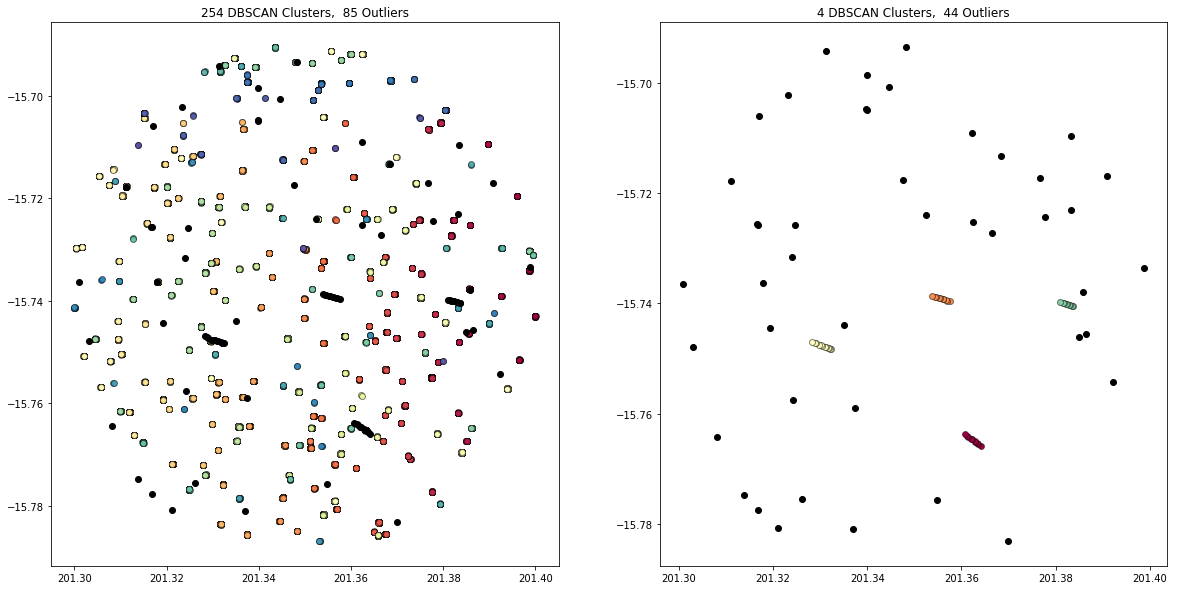

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [186]:
#plot DBSCAN on all measurements, and DBSCAN on outliers
f,(ax1,ax2)= plt.subplots(1, 2,figsize=(20,10)) 
plot_dbscan(Xx,db_1,ax1)
plot_dbscan(X_out,db_2,ax2)
plt.show()

# I. Tracklet Validation 
Using cluster results from second iteration of DBSCAN 

## Select Cluster #0 from outlier DBSCAN, add time-outlier "data" to test tracklet validation

To cluster 0, I've done two things:

1) Added an extra measurement in the tracklet path, taken a day later

2) Added a background stationary object (BSO).  While the clustering should take care of any BSOs, I still want to see if this validation method works on them. Just in case.

In [229]:
dat_m_t=Table(dat_m)
#Cluster #0 with one extra mmt a day later----------------------------------------------------------
c_ex=dat_m_t[outliers][labs==0]
c_ex.add_row(c_ex[4])
c_ex[10]['mjd']=c_ex[10]['mjd']+0.05
c_ex[10]['dec']=c_ex[10]['dec']+.0001
#Cluster #0 with extra stationary object------------------------------------------------------------
c_s=dat_m_t[outliers][labs==0]
c_s[:]['ra'] = 201.362285390197
c_s[:]['dec'] = -15.76465803771
c_s[:]['mag_auto'] = 20.1
c_so=join(c_s,dat_m_t[outliers][labs==0],join_type='outer')

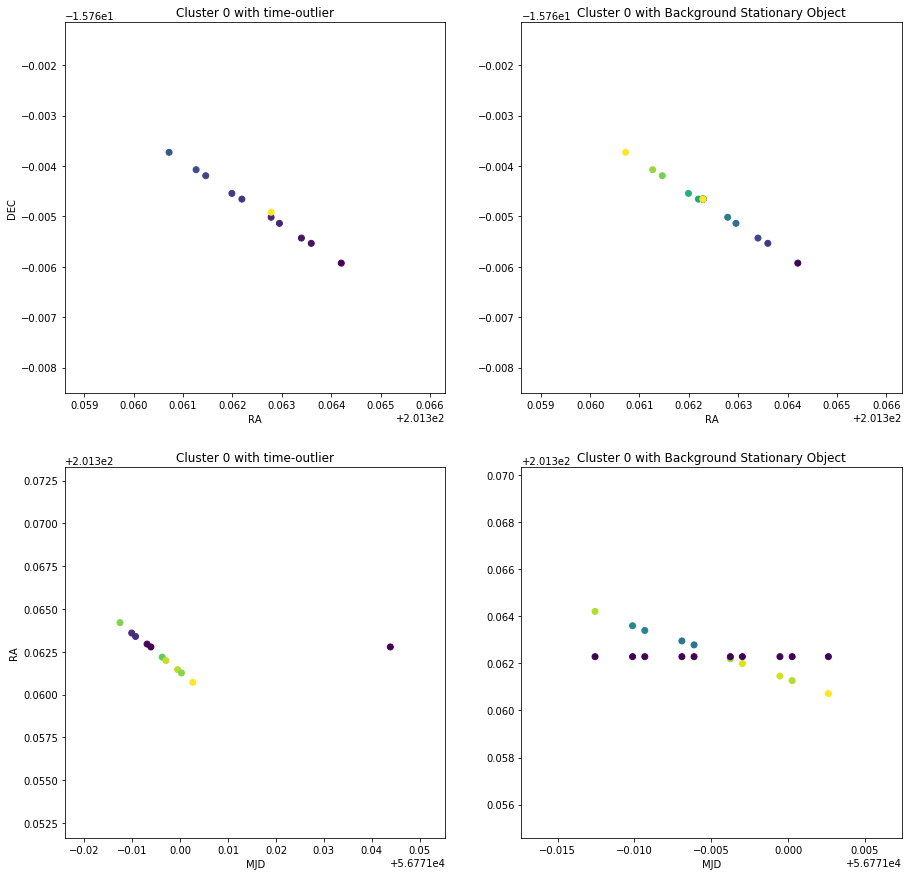

In [7]:
#plot clusters with added data; RA vs DEC, color = time (mjd)-------------------
f, ax = plt.subplots(2, 2, figsize=(15,15)) 
ax[0,0].scatter(c_ex['ra'],c_ex['dec'],c=c_ex['mjd'])
ax[0,0].set_title('Cluster 0 with time-outlier')
ax[0,0].set_ylabel('DEC')
ax[0,0].set_xlabel('RA')
ax[0,0].margins(x=-.3,y=-.3)
ax[0,1].scatter(c_so['ra'],c_so['dec'],c=c_so['mjd'])
ax[0,1].set_title('Cluster 0 with Background Stationary Object')
ax[0,1].set_xlabel('RA')
ax[0,1].margins(x=-.3,y=-.3)
#plot clusters with added data; MJD vs RA, color = magnitude (mag_auto)----------
ax[1,0].scatter(c_ex['mjd'],c_ex['ra'],c=c_ex['mag_auto'])
ax[1,0].set_title('Cluster 0 with time-outlier')
ax[1,0].set_ylabel('RA')
ax[1,0].set_xlabel('MJD')
ax[1,1].set_title('Cluster 0 with Background Stationary Object')
ax[1,1].scatter(c_so['mjd'],c_so['ra'],c=c_so['mag_auto'])
ax[1,1].set_xlabel('MJD')
ax[1,1].margins(x=-.1,y=-.1)
plt.show()

## Robust Regression for Single Time-outlier
using RANSAC from scikit-learn

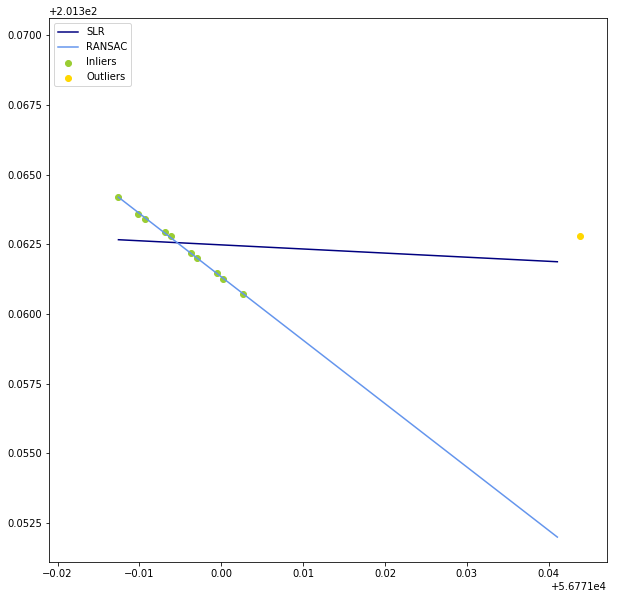

In [8]:
#Format data------------------------------------------------------------------------------
mjd=np.array(c_ex['mjd'])
X=np.reshape(mjd,(len(mjd),1))
y=np.array(c_ex['ra'])

# Fit SLR using all data------------------------------------------------------------------
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm-----------------------------------------
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models--------------------------------------------------------
line_X = np.reshape(np.arange(X.min(), X.max(),step=(X.max()-X.min())/20),(20,1))
line_y = lr.predict(line_X)  #line for SLR
line_y_ransac = ransac.predict(line_X) #line for RANSAC fit

#Plot results-----------------------------------------------------------------------------
plt.figure(figsize=(10,10))
#plot points (green for main data, yellow for outliers)
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', label='Outliers')
#plot SLR
plt.plot(line_X, line_y, color='navy', label='SLR')
#plot RANSAC line
plt.plot(line_X, line_y_ransac, color='cornflowerblue',label='RANSAC')
plt.legend(loc='upper left')
plt.show()

Perfect.

## Try same method on BSO

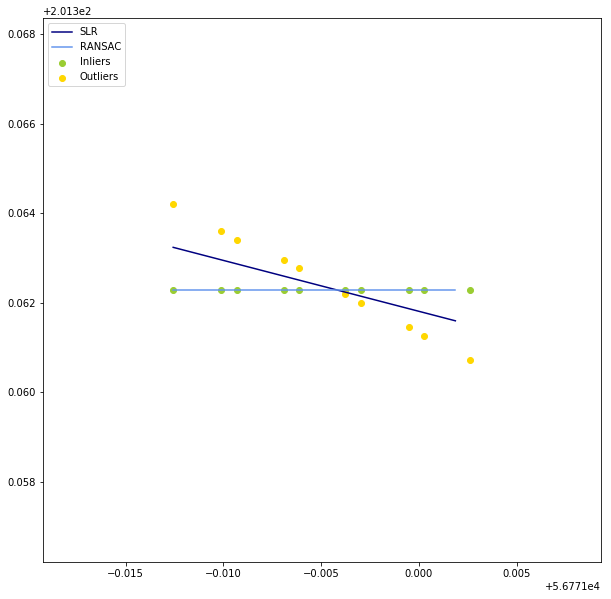

In [9]:
#Format data------------------------------------------------------------------------------
mjd=np.array(c_so['mjd'])
X=np.reshape(mjd,(len(mjd),1))
y=np.array(c_so['ra'])

# Fit SLR using all data------------------------------------------------------------------
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm-----------------------------------------
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models--------------------------------------------------------
line_X = np.reshape(np.arange(X.min(), X.max(),step=(X.max()-X.min())/20),(20,1))
line_y = lr.predict(line_X)  #line for SLR
line_y_ransac = ransac.predict(line_X) #line for RANSAC fit

#Plot results-----------------------------------------------------------------------------
plt.figure(figsize=(10,10))
#plot points (green for main data, yellow for outliers)
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', label='Outliers')
#plot SLR
plt.plot(line_X, line_y, color='navy', label='SLR')
#plot RANSAC line
plt.plot(line_X, line_y_ransac, color='cornflowerblue',label='RANSAC')
plt.legend(loc='upper left')
plt.show()

RANSAC treats measurements of the moving object as outliers, but effectively separates the moving and stationary objects.

Method adapted from https://scikit-learn.org/stable/auto_examples/linear_model/plot_ransac.html#sphx-glr-auto-examples-linear-model-plot-ransac-py

# II. Cluster Validation 
More general testing, using cluster results from first and second DBSCAN iterations

## Silhouette Analysis 

This is "a method of interpretation and validation of consistency within clusters of data."  Each member of each cluster is assigned a "silhouette" (a value, $s$), where $-1 < s < 1$.  If $s = 1$, the object is well-matched to its cluster.  If $s = -1$, the object is a poor fit to its cluster.  You get the picture.

#### Define function to plot Silhouette results

In [221]:
def plot_s(X,db,q=[]):
    
    label=db.labels_
    n_clusters=len(np.unique(label))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 9)

# 1st subplot- silhouette plot-------------------------------------------------------------------------------
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, 
    # to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X,label)
    avg_no_outlier = silhouette_score(X[label!=-1],label[label!=-1])
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg,
          " including outliers, ",avg_no_outlier," without.")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, label)

    y_lower = 10
    for i in range(-1,n_clusters-1,1):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[label == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i+1) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.8, y_lower + 0.5 * size_cluster_i, str(i))
        if (q==1):  #include silhouette score (ave. silhouette coef.) for each cluster. Only advised for small n_cluster 
            ave=np.mean(silhouette_samples(X, label)[label==i])
            ax1.text(-0.6,y_lower+0.5*size_cluster_i,ave)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])  #Clear the yaxis labels / ticks

    ax1.axvline(x=silhouette_avg, color="gray", linestyle="--") #vertical line for average silhouette score
    ax1.axvline(x=avg_no_outlier, color="red", linestyle="--") #vertical line for average silhouette score

# 2nd Plot - showing clusters------------------------------------------------------------------------------------
    colors = cm.nipy_spectral((label.astype(float)+float(1)) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.ticklabel_format(axes='both',useOffset=False)
    ax2.set_xlabel("RA")
    ax2.set_ylabel("DEC")

    plt.suptitle(("Silhouette analysis with n_clusters = %d" % n_clusters), 
                 fontsize=14, fontweight='bold')

    plt.show()

Plotting method adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 5 The average silhouette_score is : 0.20284356336475062  including outliers,  0.9423961856250431  without.


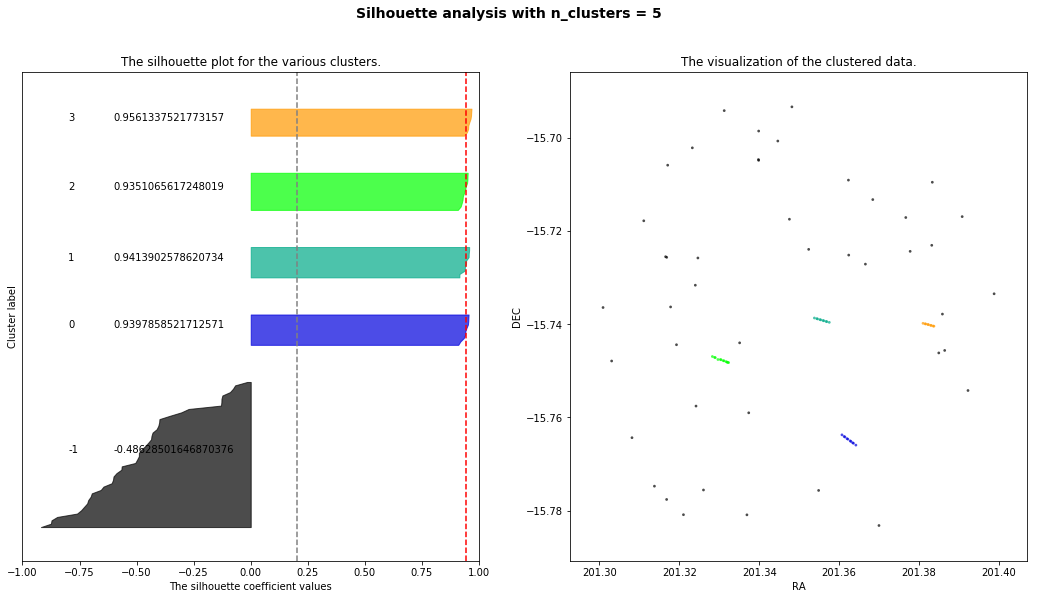

CPU times: user 232 ms, sys: 4 ms, total: 236 ms
Wall time: 232 ms


In [224]:
%%time
plot_s(X_out,db_2,1)

For n_clusters = 255 The average silhouette_score is : 0.9694225548155239  including outliers,  0.981615730224851  without.


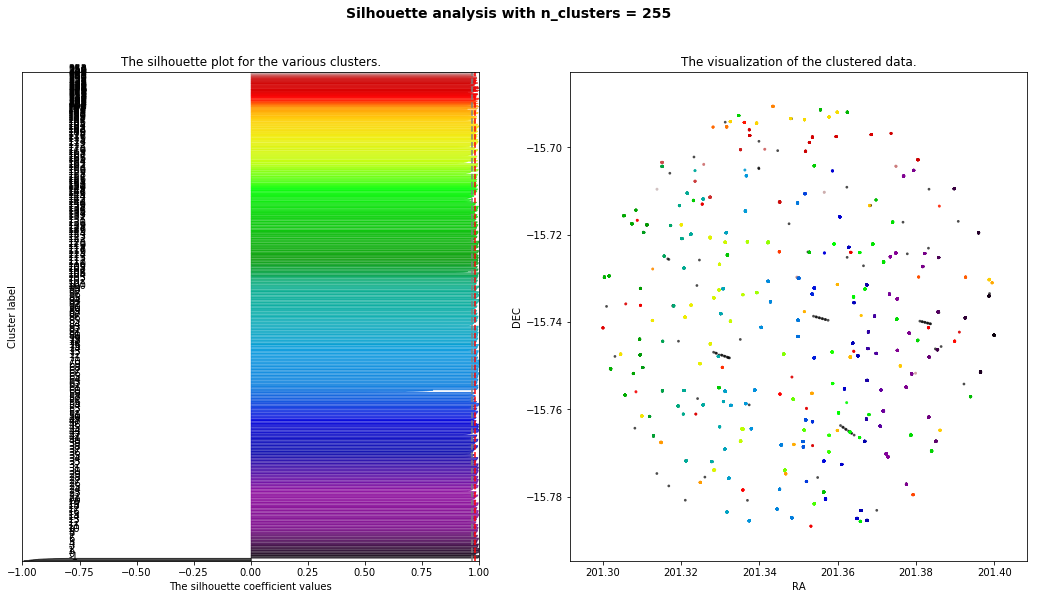

CPU times: user 46.7 s, sys: 27.8 s, total: 1min 14s
Wall time: 53.6 s


In [225]:
%%time
plot_s(Xx,db_1)

This works pretty well.  It takes a while to generate the plot, but that probably won't be necessary to do every time.  The outlier "clusters" have pretty low silhouettes, which is to be expected because those points aren't really clustered, are they?